In [ ]:
!unzip -u "/content/drive/MyDrive/GraphPointNet/anotations.zip" -d "/content/root"

print('\n\ndone!')

Archive:  /content/drive/MyDrive/GraphPointNet/anotations.zip
   creating: /content/root/mask/CT-2/
  inflating: /content/root/mask/CT-2/middle_slice_study_0939.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0940.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0941.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0942.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0943.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0944.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0945.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0946.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0947.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0948.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0949.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0950.png  
  inflating: /content/root/mask/CT-2/middle_slice_study_0951.png  
  inflating: /content/root/ma

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
from PIL import Image
import os

# Define the input folder containing your images
input_folder = '/content/root/mask/CT-2'

# Define the output folder where grayscale images will be saved
output_folder = '/content/M_CT_2'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through all the image files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Open the image
        image = Image.open(os.path.join(input_folder, filename))

        # Convert the image to grayscale
        gray_image = image.convert('L')

        # Save the grayscale image with the same filename in the output folder
        gray_image.save(os.path.join(output_folder, filename))

print("Conversion to grayscale completed.")

Conversion to grayscale completed.


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = '/content/IM_CT_2'
mask_directory = '/content/M_CT_2'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
framObjTrain = {'img': [],
                'mask': []
               }

def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=256):
    imgNames = os.listdir(imgPath)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for imgName in imgNames:
        # Check if the file is an image file
        if imgName.endswith('.png'):
            img = plt.imread(imgAddr + imgName)
            maskName = imgName.split('.png')[0] + '.png'
            mask = plt.imread(maskAddr + maskName)

            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            frameObj['img'].append(img)
            frameObj['mask'].append(mask)

    return frameObj


In [ ]:
# loading benign samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/IM_CT_2'
                        , maskPath = '/content/M_CT_2'
                         , shape = 256)

In [ ]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(framObjTrain['img'], framObjTrain['mask'], test_size = 0.10, random_state = 42)

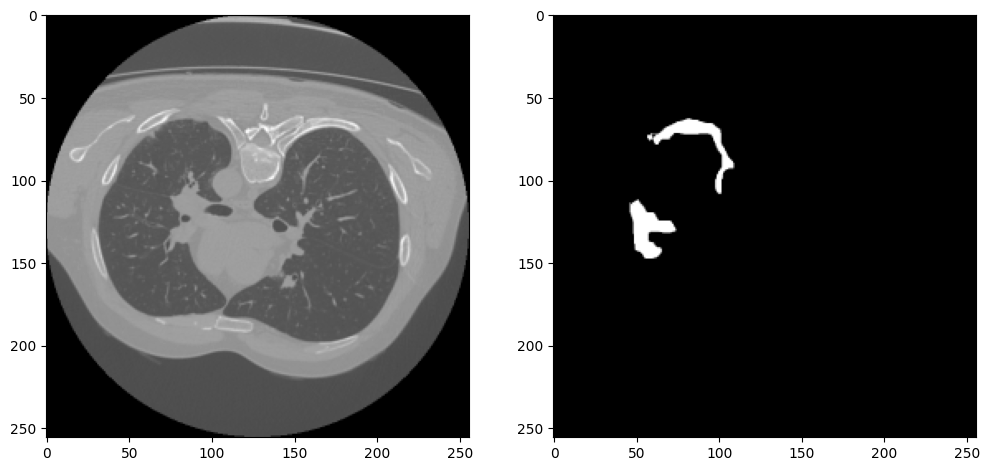

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 1)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
#Model Defination
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 1))
rkoshaheds_model = GiveMeUnet(inputs, droupouts= 0.07)
rkoshaheds_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
rkoshaheds_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normalization[0][0

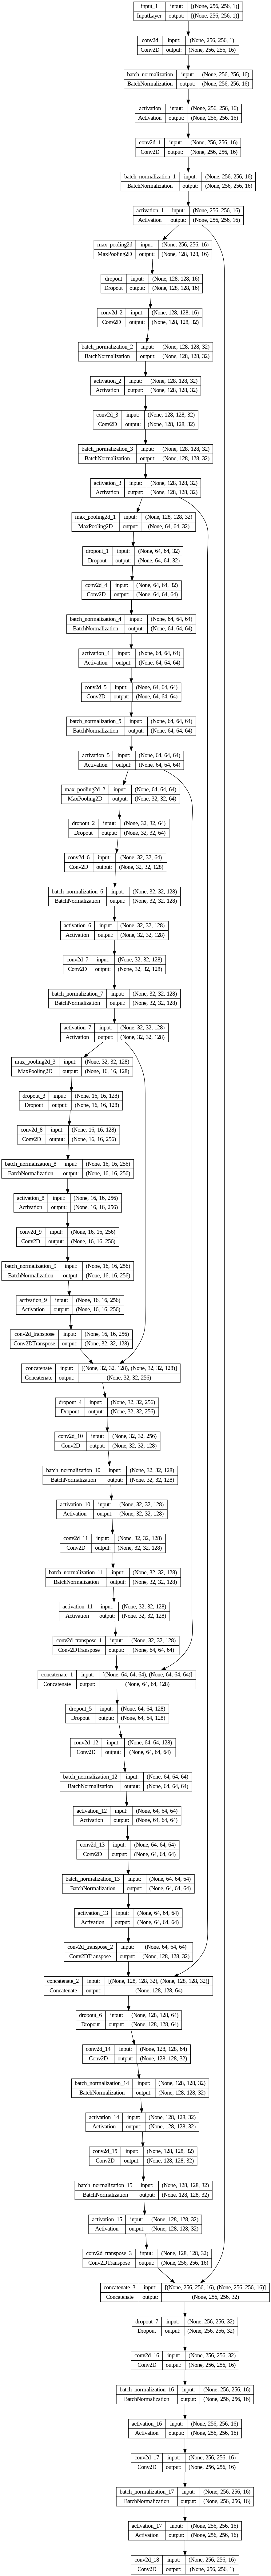

In [ ]:
tf.keras.utils.plot_model(
    rkoshaheds_model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
hisVal = rkoshaheds_model.fit(np.array(X_train), np.array(y_train), epochs = 200)

Epoch 1/200
4/4 [==============================] - 36s 3s/step - loss: 0.4502 - accuracy: 0.8919
Epoch 2/200
4/4 [==============================] - 2s 434ms/step - loss: 0.3854 - accuracy: 0.9484
Epoch 3/200
4/4 [==============================] - 2s 424ms/step - loss: 0.3501 - accuracy: 0.9666
Epoch 4/200
4/4 [==============================] - 2s 420ms/step - loss: 0.3177 - accuracy: 0.9766
Epoch 5/200
4/4 [==============================] - 2s 419ms/step - loss: 0.2909 - accuracy: 0.9808
Epoch 6/200
4/4 [==============================] - 2s 422ms/step - loss: 0.2693 - accuracy: 0.9828
Epoch 7/200
4/4 [==============================] - 2s 422ms/step - loss: 0.2520 - accuracy: 0.9838
Epoch 8/200
4/4 [==============================] - 2s 421ms/step - loss: 0.2374 - accuracy: 0.9841
Epoch 9/200
4/4 [==============================] - 2s 416ms/step - loss: 0.2252 - accuracy: 0.9842
Epoch 10/200
4/4 [==============================] - 2s 418ms/step - loss: 0.2146 - accuracy: 0.9842
Epoch 11/20

In [ ]:
retVal = rkoshaheds_model.fit(np.array(X_test), np.array(y_test), epochs = 200)

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.0612 - accuracy: 0.9858
Epoch 2/200
1/1 [==============================] - 0s 227ms/step - loss: 0.0372 - accuracy: 0.9909
Epoch 3/200
1/1 [==============================] - 0s 223ms/step - loss: 0.0308 - accuracy: 0.9921
Epoch 4/200
1/1 [==============================] - 0s 238ms/step - loss: 0.0262 - accuracy: 0.9927
Epoch 5/200
1/1 [==============================] - 0s 224ms/step - loss: 0.0235 - accuracy: 0.9933
Epoch 6/200
1/1 [==============================] - 0s 229ms/step - loss: 0.0215 - accuracy: 0.9936
Epoch 7/200
1/1 [==============================] - 0s 229ms/step - loss: 0.0198 - accuracy: 0.9939
Epoch 8/200
1/1 [==============================] - 0s 226ms/step - loss: 0.0185 - accuracy: 0.9943
Epoch 9/200
1/1 [==============================] - 0s 225ms/step - loss: 0.0173 - accuracy: 0.9946
Epoch 10/200
1/1 [==============================] - 0s 228ms/step - loss: 0.0163 - accuracy: 0.9949
Epoch 11/200

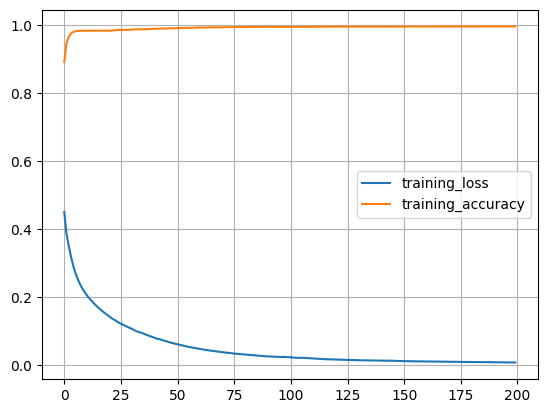

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

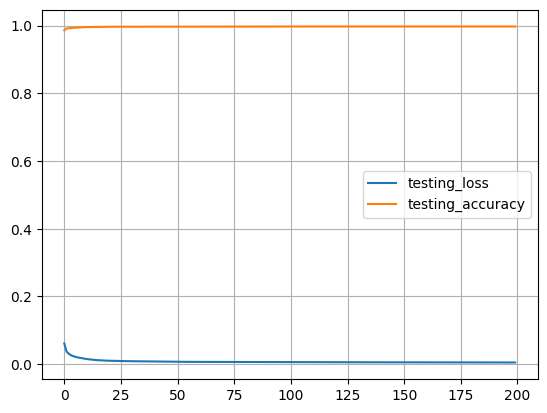

In [ ]:
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

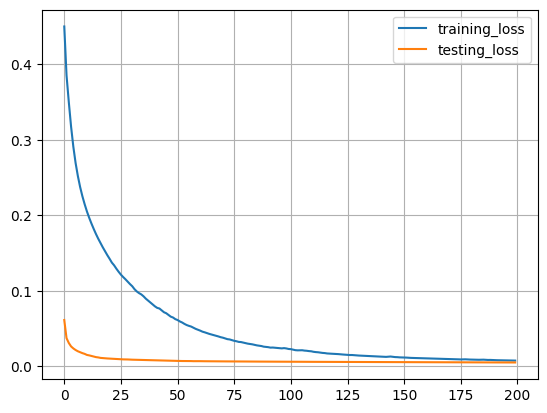

In [ ]:
plt.plot(hisVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['loss'], label = 'testing_loss')
plt.legend()
plt.grid(True)

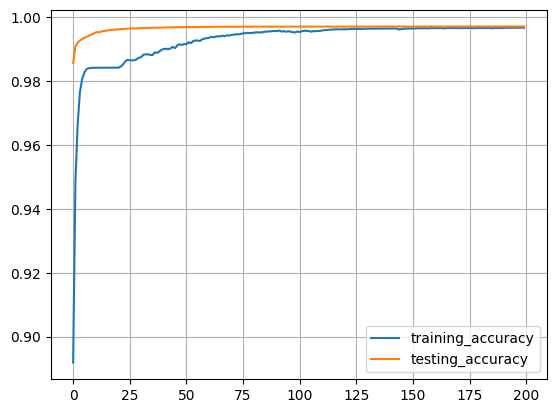

In [ ]:
plt.plot(hisVal.history['accuracy'], label = 'training_accuracy')
plt.plot(retVal.history['accuracy'], label = 'testing_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import confusion_matrix

def dice_coefficient(y_true, y_pred):
    smooth = 1e-15
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Custom callback to compute Dice score after each epoch
class DiceScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        super(DiceScoreCallback, self).__init__()
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_test)
        dice = dice_coefficient(self.y_test, y_pred).numpy()
        print(f'\nDice Score: {dice}')

# Define your UNet model and compile it

# Instantiate model
inputs = tf.keras.layers.Input((256, 256, 1))
rkoshaheds_model = GiveMeUnet(inputs, droupouts=0.07)

# Compile model
rkoshaheds_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of model
rkoshaheds_model.summary()

# Fit the model with callbacks
retVal = rkoshaheds_model.fit(np.array(X_train), np.array(y_train), epochs=200,
                               validation_data=(np.array(X_test), np.array(y_test)),
                               callbacks=[DiceScoreCallback(np.array(X_test), np.array(y_test))])


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         160       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 256, 256, 16)         64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_36 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_36

1/1 [==============================] - 0s 23ms/step

Dice Score: 0.026394546031951904
4/4 [==============================] - 2s 497ms/step - loss: 0.6582 - accuracy: 0.6469 - val_loss: 12.6405 - val_accuracy: 0.0308
Epoch 3/200
1/1 [==============================] - 0s 22ms/step

Dice Score: 0.026072777807712555
4/4 [==============================] - 2s 498ms/step - loss: 0.5498 - accuracy: 0.8808 - val_loss: 14.5703 - val_accuracy: 0.0309
Epoch 4/200
1/1 [==============================] - 0s 23ms/step

Dice Score: 0.026556694880127907
4/4 [==============================] - 2s 498ms/step - loss: 0.4642 - accuracy: 0.9554 - val_loss: 12.3345 - val_accuracy: 0.0226
Epoch 5/200
1/1 [==============================] - 0s 24ms/step

Dice Score: 0.02618713490664959
4/4 [==============================] - 2s 507ms/step - loss: 0.4069 - accuracy: 0.9735 - val_loss: 10.6576 - val_accuracy: 0.0500
Epoch 6/200
1/1 [==============================] - 0s 33ms/step

Dice Score: 0.021001100540161133
4/4

In [ ]:
#Testing
def predict16 (valMap, model, shape = 224):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]

    imgProc = img [0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title(' image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, rkoshaheds_model)
Plotter(actuals[16], sixteenPrediction[16][:,:,], masks[16])

1/1 [==============================] - 0s 24ms/step


IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
cv2.imwrite(r'test3.png',sixteenPrediction[7][:,:,0])

True

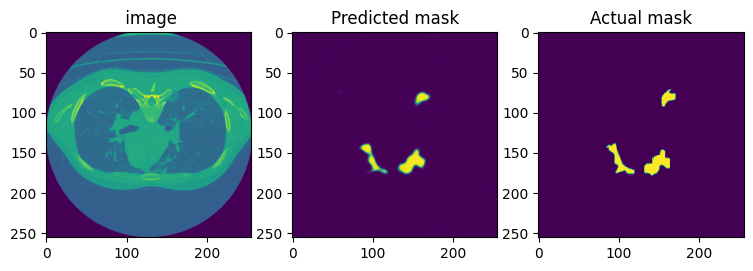

In [ ]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])